In [134]:
import pandas as pd
from gensim import models
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import *

In [135]:
trainDF = pd.read_csv("Data/train.csv")
testDF = pd.read_csv("Data/test.csv")

trainDF.question1.fillna('abc', inplace=True)
trainDF.question2.fillna('abc', inplace=True)

In [136]:
def cleanQuestion(question):
    """Functions to clean question pairs
    """
    # convert to lower case
    question = question.lower()
#     question = question.replace()
    question = question.decode('utf-8')
    stop = stopwords.words('english')
    stemmer = PorterStemmer()
    questions = re.sub(r'[^\x00-\x7F]+', ' ', question, flags=re.MULTILINE)
    question = ' '.join([word for word in question.split() if word not in stop])
    question = ' '.join([stemmer.stem(word) for word in question.split()])
    # remove extra spaces
    question = re.sub(r'[\s]+', ' ', question, flags=re.MULTILINE)
    # remove all punctuations
    question = re.sub(r'[^a-zA-Z]', ' ', question, flags=re.MULTILINE)
    return question


In [137]:
def getLabeledSentence(questions, label):
    labeledQuestions=[]
    for uid, line in enumerate(questions):
        labeledQuestions.append( models.doc2vec.LabeledSentence(words=line.split(), tags=[label+str(uid)]))
    
    return labeledQuestions

In [138]:
trainDF.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [139]:
trainDF.question1 = trainDF.question1.apply(cleanQuestion)
trainDF.question2 = trainDF.question2.apply(cleanQuestion)

In [140]:
trainDF.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guid invest share market india,step step guid invest share market,0
1,1,3,4,stori kohinoor koh i noor diamond,would happen indian govern stole kohinoor koh...,0
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0
3,3,7,8,mental lonely solv it,find remaind math math divid,0
4,4,9,10,one dissolv water quikli sugar salt methan c...,fish would surviv salt water,0


In [141]:
labeledQuestions1 = getLabeledSentence(trainDF.question1.tolist(), 'question1')
labeledQuestions2 = getLabeledSentence(trainDF.question2.tolist(), 'question2')

In [142]:
model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
labeledQuestions = labeledQuestions1 + labeledQuestions2

In [143]:
model.build_vocab(labeledQuestions)

In [144]:
model.train(labeledQuestions)
# for epoch in range(10):
#     model.train(labeledQuestions)
#     model.alpha -= 0.002  # decrease the learning rate`
#     model.min_alpha = model.alpha # fix the learning rate, no decay

25993840

In [145]:
model.save('Models/4_22model_processed')# 35900484 for raw

In [56]:
model_loaded = models.Doc2Vec.load('Models/4_8model')

In [146]:
similarity = []
for i in range(len(labeledQuestions1)):
    similarity.append(model.docvecs.similarity('question1%d'%i, 'question2%d'%i))

In [147]:
similarityDF = pd.DataFrame({'similarity': similarity})
similarityDF['y'] = trainDF.is_duplicate

In [148]:
similarityDF.head()

,similarity,y
0,0.513266,0
1,0.431063,0
2,-0.119770,0
3,-0.295447,0
4,0.548447,0


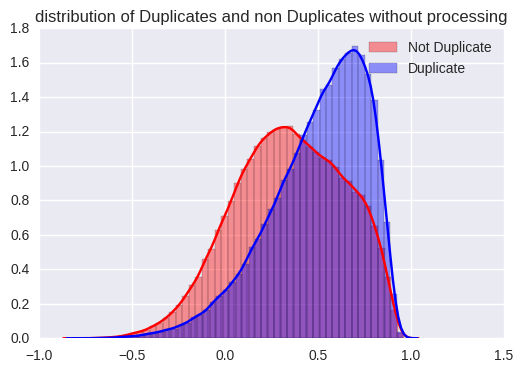

In [101]:
#stop
import seaborn as sns
%matplotlib inline
ax = sns.distplot(similarityDF[similarityDF.y==0].similarity.tolist(), hist=True, label="Not Duplicate", color='red')
ax = sns.distplot(similarityDF[similarityDF.y==1].similarity.tolist(), hist=True, label="Duplicate", color='blue')
ax.axes.set_title("distribution of Duplicates and non Duplicates without processing")
ax.legend()

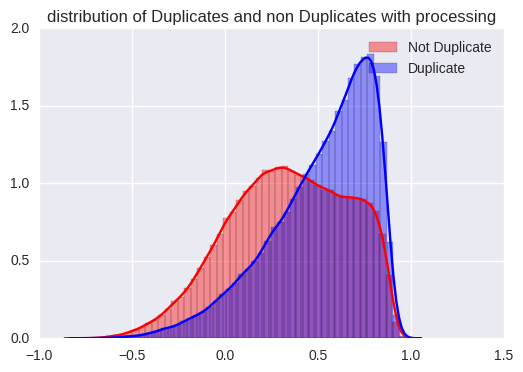

In [151]:
import seaborn as sns
%matplotlib inline
ax = sns.distplot(similarityDF[similarityDF.y==0].similarity.tolist(), hist=True, label="Not Duplicate", color='red')
ax = sns.distplot(similarityDF[similarityDF.y==1].similarity.tolist(), hist=True, label="Duplicate", color='blue')
ax.axes.set_title("distribution of Duplicates and non Duplicates with processing")
ax.legend()

In [ ]:
vectors1 = []
vectors2 = []
print "Fetching Vectors..."
for i in range(len(labeledQuestions1)*2):
    if i< len(labeledQuestions1):
        vectors1.append(model.docvecs[i])
    else:
        vectors2.append(model.docvecs[i])
import ipdb; ipdb.set_trace()

vectors1 = np.asarray(vectors1)
vectors2 = np.asarray(vectors2)

labels = np.asarray(train.is_duplicate)
